# Mushroom Dataset: Binary Classification Project

## Introduction

This projects aim to build a binary classification model to predict whether a mushroom is edible or poisonous based on its characteristics. A [curated version of the Mushroom Dataset](http://https://www.kaggle.com/datasets/prishasawhney/mushroom-dataset) sourced from the UCI Library was used for the task. The dataset has been cleaned and preprocessed to make it suitable for ML tasks.

## Dataset Overview

The Mushroom Dataset contains nine columns, representing specific attributes of mushrooms:

1. **Cap Diameter**: The diameter of the mushroom cap.
2. **Cap Shape**: The shape of the mushroom cap.
3. **Gill Attachment**: The attachment of gills to the stem.
4. **Gill Color**: The color of the gills.
5. **Stem Height**: The height of the mushroom stem.
6. **Stem Width**: The width of the mushroom stem.
7. **Stem Color**: The color of the mushroom stem.
8. **Season**: The season in which the mushroom was observed.
9. **Target Class**: This column serves as the target variable for classification, indicating whether the mushroom is edible or poisonous. It consists of binary values, where 0 represents edible mushrooms and 1 the poisonous ones.

The project involves exploratory data analysis, transformation of features, model selection and training, evaluation, and interpretation.

## Exploratory Data Analysis

The primary objective of this EDA is to:

- Understand the distribution of dataset features.
- Explore relationships between features and the target class.
- Detect any outliers or anomalies that may require further investigation.

In [1]:
#Import neccessary libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer, Normalizer, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import shap

import warnings
warnings.filterwarnings("ignore")

#Read in the dataset
df = pd.read_csv("/kaggle/input/mushroom-dataset/mushroom_cleaned.csv")

# Define and set color palette
col_palette = ['#8DA0CB', '#6B83A6', '#4B6584', '#344E73', '#2B3A67', '#23315B', '#1C2850', '#162046', '#111739']
sns.set_palette(col_palette)
column_colors = {col: color for col, color in zip(df.columns, col_palette)}


In [2]:
#Look at the dataset summary and drop any duplicated rows
print(df.shape)
print(df.head())
print(df.info())
print(df.describe())
print(df.median())
df.drop_duplicates(inplace=True)

(54035, 9)
   cap-diameter  cap-shape  gill-attachment  gill-color  stem-height  \
0          1372          2                2          10     3.807467   
1          1461          2                2          10     3.807467   
2          1371          2                2          10     3.612496   
3          1261          6                2          10     3.787572   
4          1305          6                2          10     3.711971   

   stem-width  stem-color    season  class  
0        1545          11  1.804273      1  
1        1557          11  1.804273      1  
2        1566          11  1.804273      1  
3        1566          11  1.804273      1  
4        1464          11  0.943195      1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54035 entries, 0 to 54034
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cap-diameter     54035 non-null  int64  
 1   cap-shape        54035 non-null  in

In [3]:
X = df.drop('class', axis=1)  
y = df['class'] 
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Exploration of Target Variable: Class

This part provides an overview of the distribution of classes within the dataset, focusing on the target variable: the 'class' column. The 'class' variable demonstrates a balanced distribution, which is an advantage for machine learning tasks.

class
1    29372
0    24360
Name: count, dtype: int64


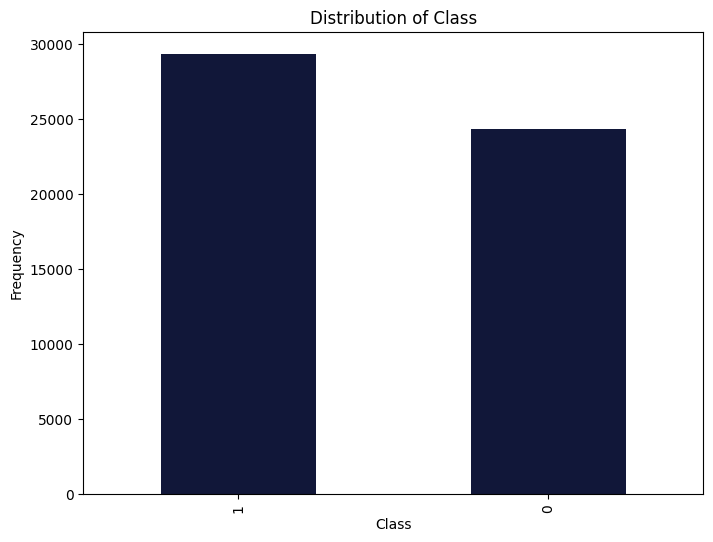

In [4]:
print(df['class'].value_counts())
plt.figure(figsize=(8, 6))
df['class'].value_counts().plot(kind='bar',color=column_colors['class'])
plt.title('Distribution of Class')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

## Visualizing categorical features

Following the initial analysis, the next stage involved computing the normalized counts of categorical features and presenting them visually. Each feature has between 4 and 11 distinct categories. However, the categories lack balance, unlike the target variable.

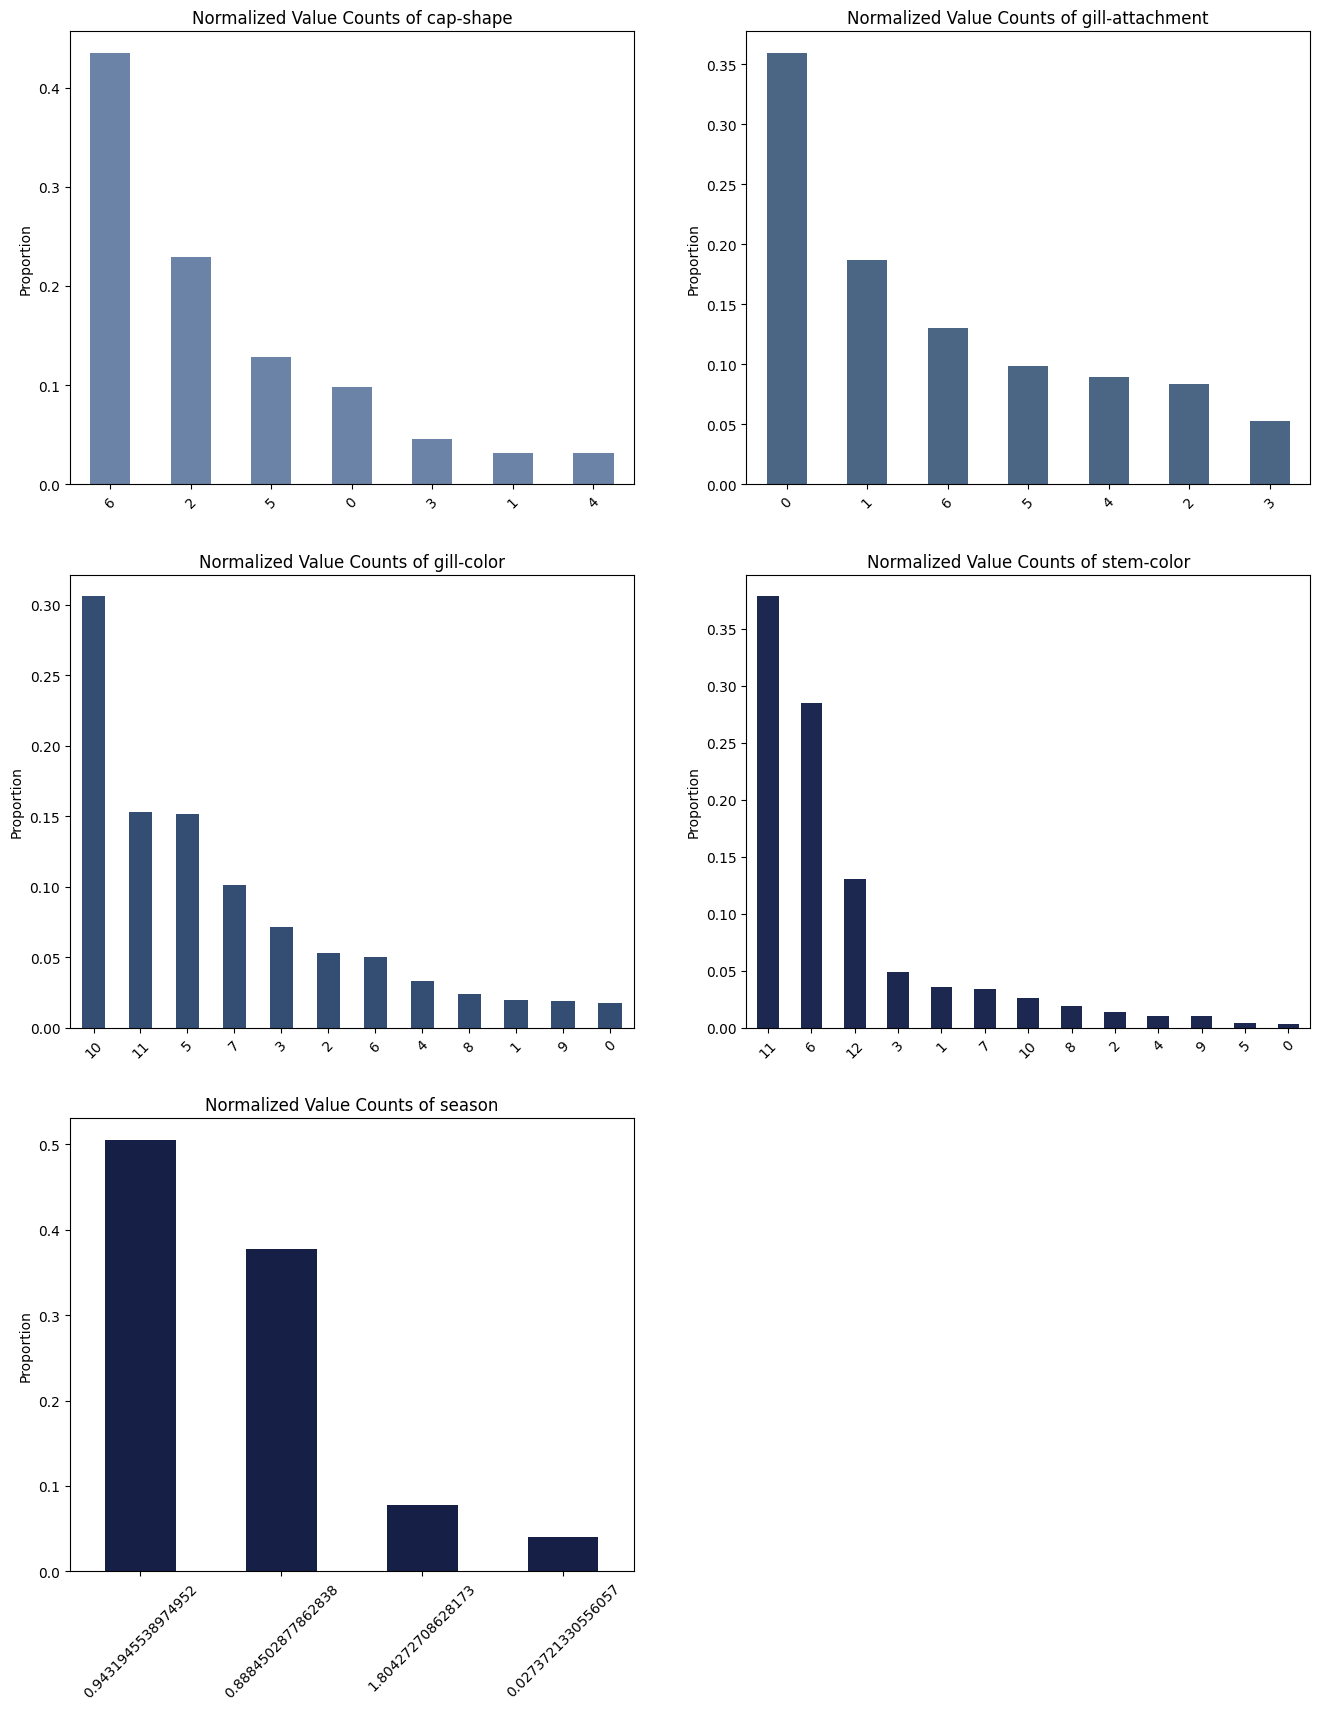

In [5]:
columns = ['cap-shape', 'gill-attachment','gill-color', 'stem-color', 'season']

fig, axes = plt.subplots(3, 2, figsize=(16, 20))
axes = axes.flatten()
for i, col in enumerate(columns):
    ax = axes[i]
    value_counts_norm = df[col].value_counts(normalize=True)
    value_counts_norm.plot(kind='bar', ax=ax, color=column_colors[col])
    ax.set_title(f'Normalized Value Counts of {col}')
    ax.set_xlabel(None)
    ax.set_ylabel('Proportion')
    ax.set_xticklabels(value_counts_norm.index, rotation=45)

fig.delaxes(axes[-1])

plt.show()


## Visualizing numerical features

The numerical features in the Mushroom Dataset exhibit a right-skewed distribution, indicative of potential multimodality. This characteristic, along with the presence of outliers, makes it important to look for appropriate transformations and modeling strategies. 

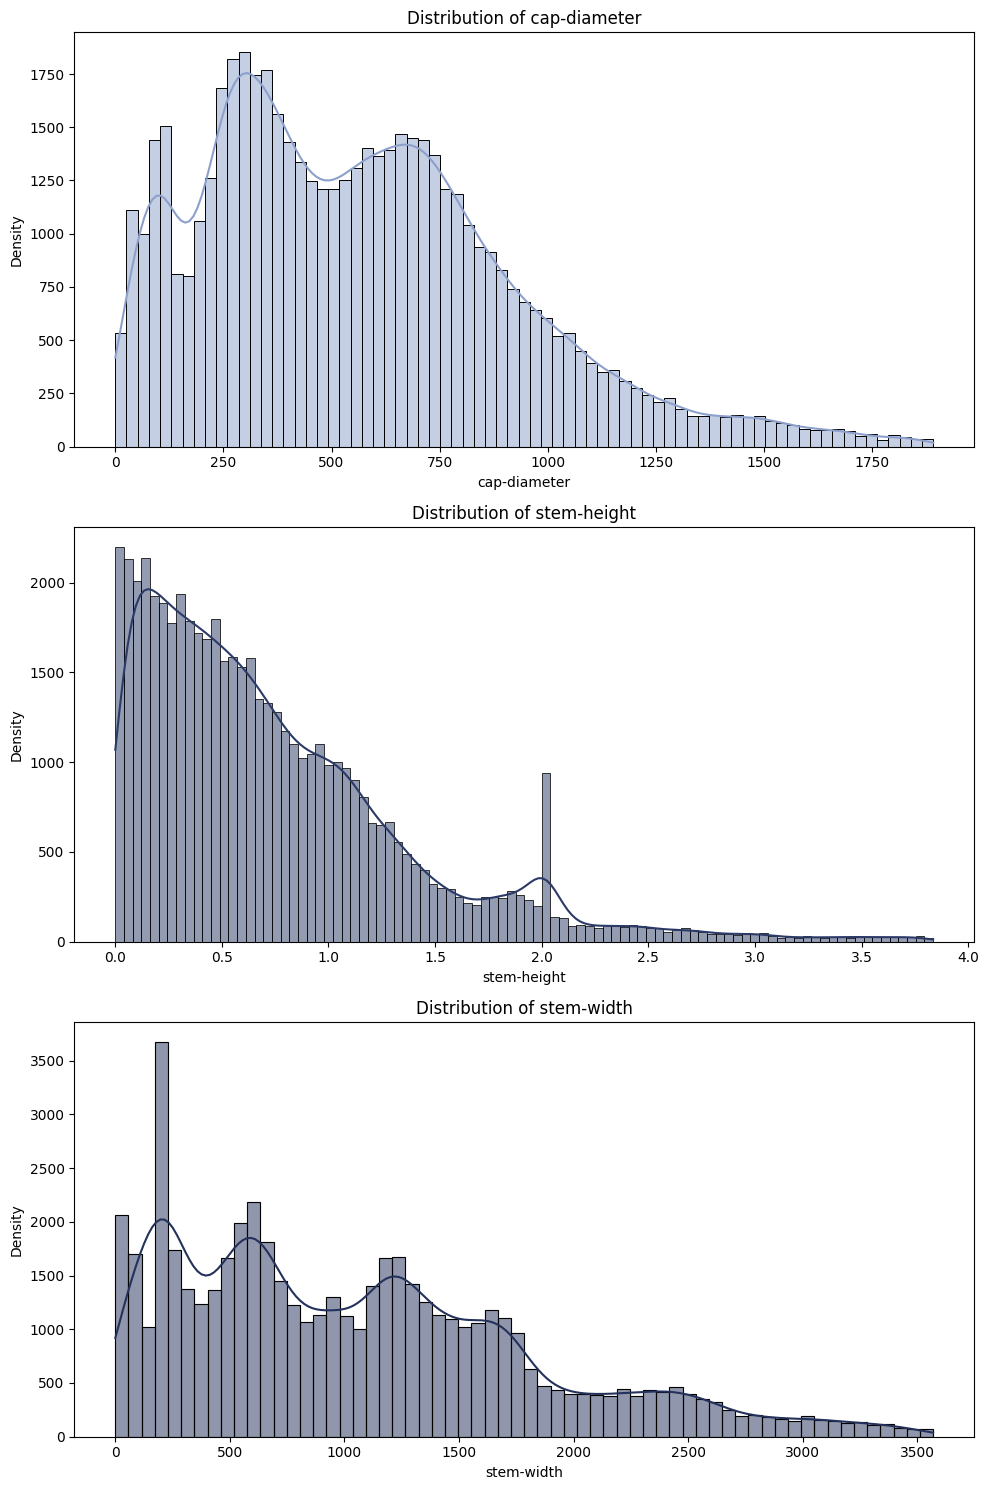

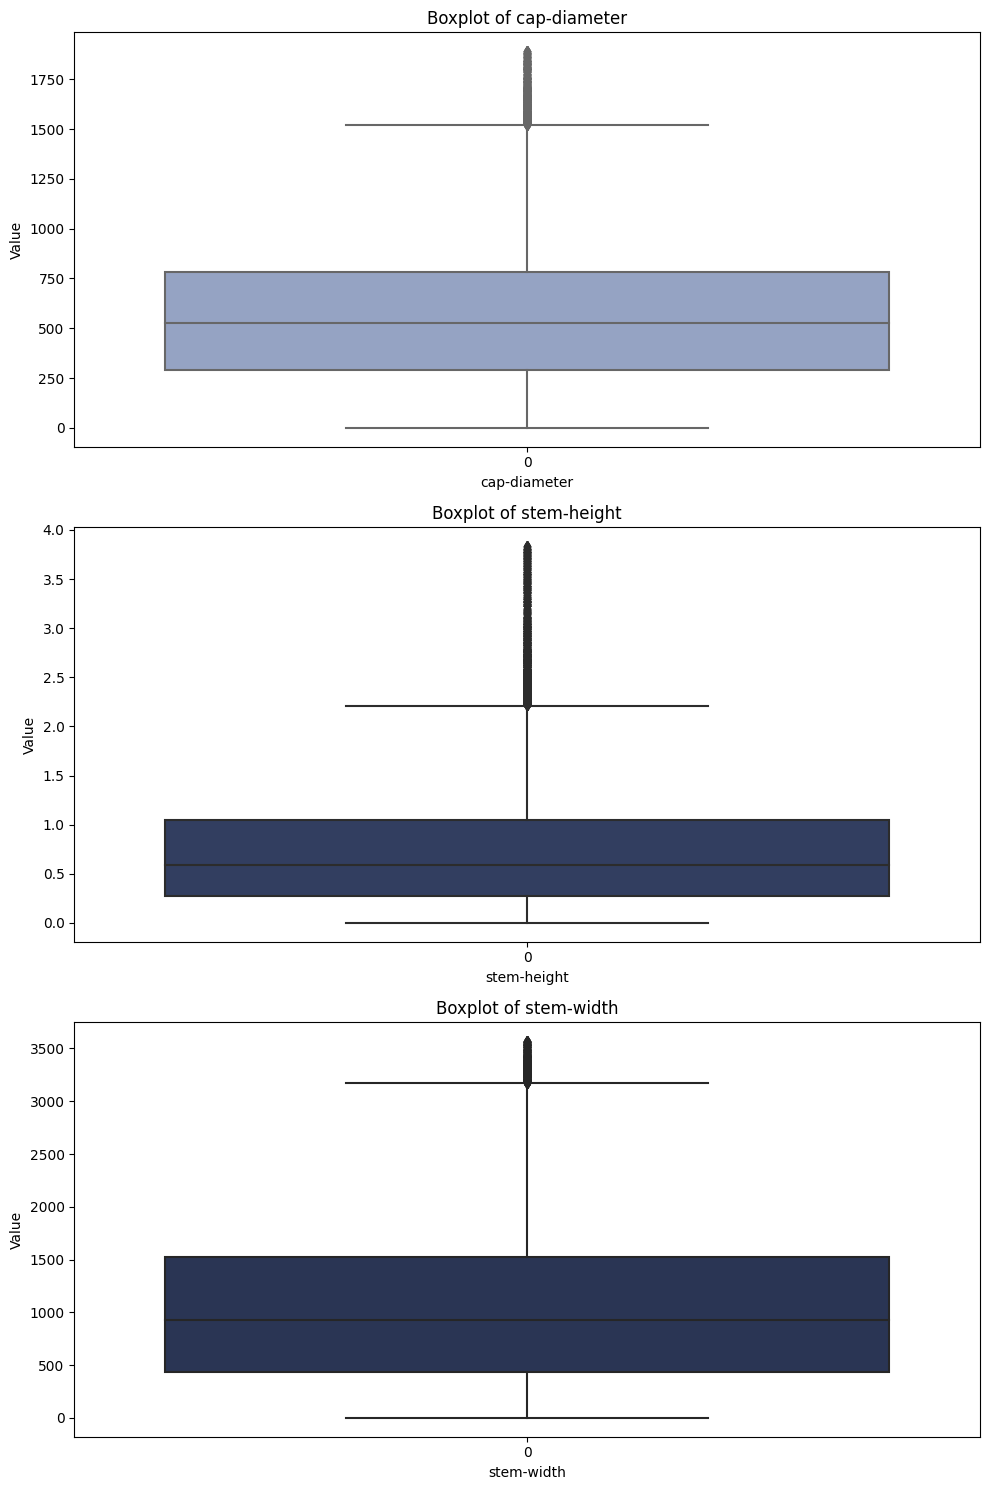

In [6]:
num_columns = ['cap-diameter', 'stem-height', 'stem-width']

fig, axes = plt.subplots(3, 1, figsize=(10, 15))
for i, col in enumerate(num_columns):
    ax = axes[i]
    sns.histplot(df[col], kde=True, ax=ax, color=column_colors[col])
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 1, figsize=(10, 15))
for i, col in enumerate(num_columns):
    ax = axes[i]
    sns.boxplot(df[col], ax=ax, color=column_colors[col])  
    ax.set_title(f'Boxplot of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()



In [7]:
# Calculate IQR and proportion of outliers in numerical columns
for i, col in enumerate(num_columns):
    # Calculate the Interquartile Range (IQR) of the column
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    print(f"IQR of {col}: {iqr}")
    
    # Calculate lower outliers
    lower_outliers = df[df[col] < q1 - 1.5 * iqr]
    proportion_lower_outliers = len(lower_outliers) / len(df)
    print(f"Number of lower outliers in {col}: {len(lower_outliers)}")
    print(f"Proportion of lower outliers in {col}: {proportion_lower_outliers:.2f}")
    
    # Calculate upper outliers
    upper_outliers = df[df[col] > q3 + 1.5 * iqr]
    proportion_upper_outliers = len(upper_outliers) / len(df)
    print(f"Number of upper outliers in {col}: {len(upper_outliers)}")
    print(f"Proportion of upper outliers in {col}: {proportion_upper_outliers:.2f}")


IQR of cap-diameter: 492.0
Number of lower outliers in cap-diameter: 0
Proportion of lower outliers in cap-diameter: 0.00
Number of upper outliers in cap-diameter: 955
Proportion of upper outliers in cap-diameter: 0.02
IQR of stem-height: 0.7767542445287261
Number of lower outliers in stem-height: 0
Proportion of lower outliers in stem-height: 0.00
Number of upper outliers in stem-height: 1851
Proportion of upper outliers in stem-height: 0.03
IQR of stem-width: 1097.0
Number of lower outliers in stem-width: 0
Proportion of lower outliers in stem-width: 0.00
Number of upper outliers in stem-width: 716
Proportion of upper outliers in stem-width: 0.01


## Plotting correlation heatmap of the dataset

In the heatmap visualization of the Mushroom Dataset, it can be observed that the correlation between 'stem height' and 'class' is 0.18. However, overall, there are no strong correlations with the target variable evident at this point of the analysis. This suggests that the numerical features may not have significant linear relationships with each other and further exploration and analysis are necessary to uncover potential patterns or associations within the data.

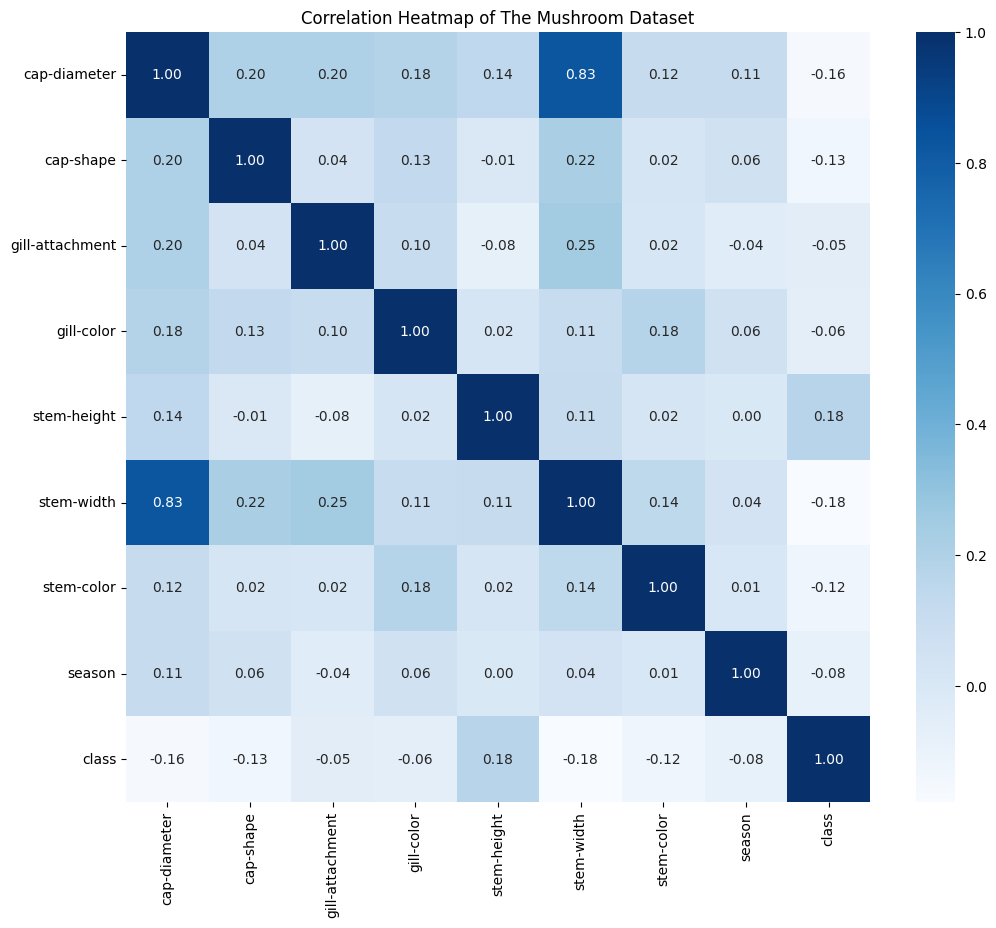

In [8]:
# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='Blues')
plt.title('Correlation Heatmap of The Mushroom Dataset')
plt.show()

## Preparing the Dataset For Modelling

In this section, the dataset was prepared for modeling. First, the dataset was split into training and testing sets to ensure that one portion of the data was used for training the model, while another was reserved for evaluating its performance.

Next, various techniques, including StandardScaler, QuantileTransformer, PowerTransformer, and MinMaxScaler, were applied to the numerical features to select appropriate transformers for the preprocessing step. The transformed distributions of the numerical features were visualized using histograms to check how each transformation affected the distribution of the data.

In [9]:
#Split the dataset into train and test sets
X = df.drop(columns=['class'])
Y = df['class']
X_train, X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2, shuffle=True, random_state=42)

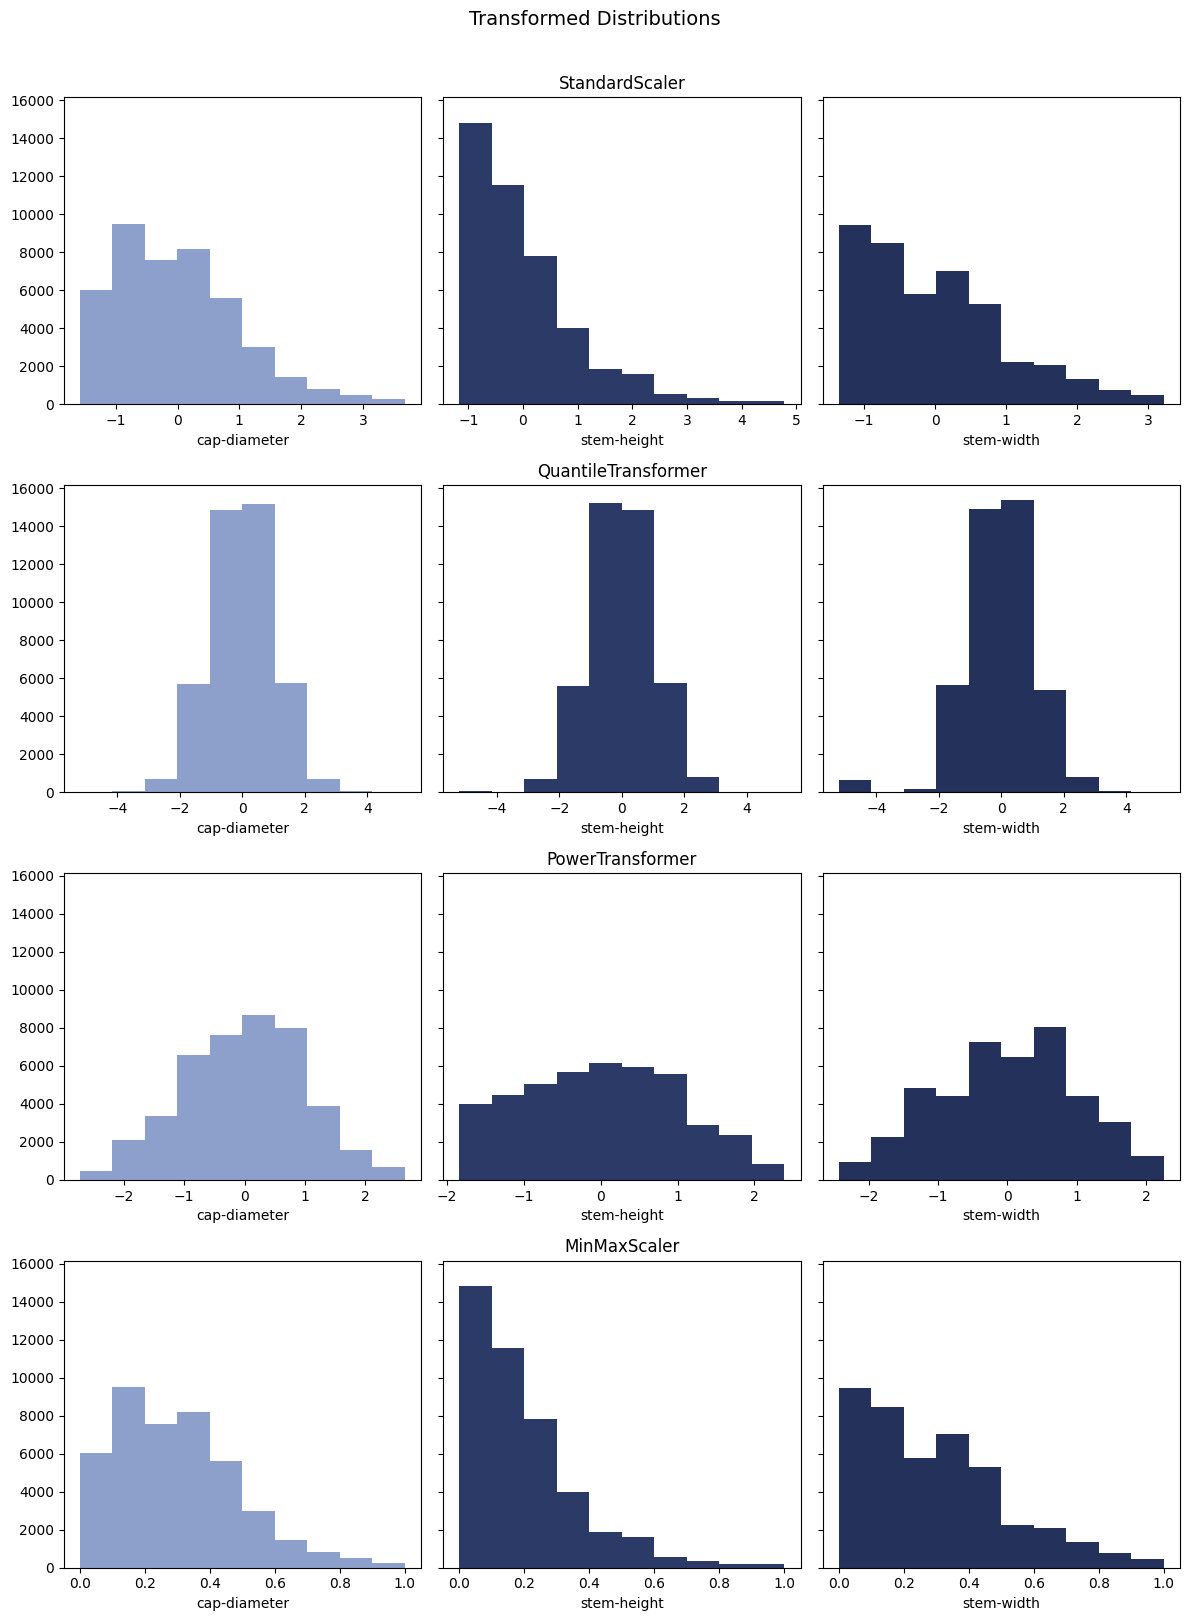

In [10]:
#Transform and plot numerical features
num_columns = ['cap-diameter', 'stem-height', 'stem-width']
transformers = [
    StandardScaler(),
    QuantileTransformer(output_distribution='normal', random_state=0),
    PowerTransformer(standardize=True),
    MinMaxScaler()
]

fig, axs = plt.subplots(len(transformers), 3, figsize=[12, 4 * len(transformers)], sharey=True)
fig.suptitle("Transformed Distributions", fontsize=14, y=1.01)

for i, t in enumerate(transformers):
    transformation = t
    X_train_transformed = transformation.fit_transform(X_train[num_columns])
    df_transformed = pd.DataFrame(X_train_transformed, columns=num_columns)
    
    axs[i, 0].hist(df_transformed['cap-diameter'], color=column_colors['cap-diameter'])
    axs[i, 0].set_xlabel('cap-diameter')
    
    axs[i, 1].hist(df_transformed['stem-height'], color=column_colors['stem-height'])
    axs[i, 1].set_xlabel('stem-height')
    axs[i, 1].set_title(type(transformation).__name__)

    axs[i, 2].hist(df_transformed['stem-width'], color=column_colors['stem-width'])
    axs[i, 2].set_xlabel('stem-width')
    
plt.tight_layout()
plt.show()

As can be seen above and based on previous analysis, the numerical features exhibited right-skewed distributions with the presence of outliers. To address this, QuantileTransformer was selected for 'cap-diameter' and 'stem-height', while 'stem-width' was transformed using PowerTransformer.

## Model Selection Stage

This stage aimed at finding the optimal classification model for further refinement with hyperparameter tuning. The evaluation criterion employed for comparing models was the area under the ROC curve,ROC AUC. This metric is suitable for binary classification tasks as it provides insight into a model's ability to discriminate between classes across various thresholds.

4 classification algorithms were considered in the evaluation process: 

* Logistic Regression
* Random Forest
* XGBoost
* Support Vector Machine (SVM)

Each model was subjected to 3-fold cross-validation, to obtain a better performance estimate. The resulting ROC AUC scores were visualized using a boxplots to enable a comparison of the models' distributions of performance metrics.

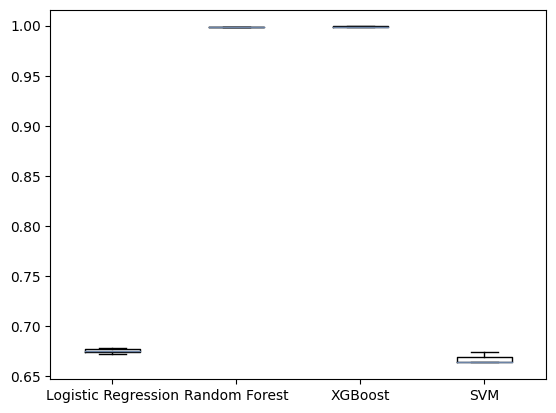

In [11]:
scoring_metric = 'roc_auc' 

# Define the models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

# Loop through the models' values
results = []
model_names = []
for model_name, model in models.items():
    model_names.append(model_name)
    kf = KFold(n_splits=3, random_state=12, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring=scoring_metric)
    results.append(cv_results)

# Plot boxplot with labels
plt.boxplot(results, labels=model_names)
plt.show()


After evaluating the models, it was observed that both XGBoost and Random Forest showed superior performance compared to Logistic Regression and Support Vector Machine. XGB and RF achieved ROC AUC scores exceeding 0.95 on the training set.

In contrast, SVM demonstrated the poorest performance among the evaluated models, while Logistic Regression only marginally outperformed SVM, with both models yielding ROC AUC scores below 0.7.

Given the results of this test, Random Forest was selected as the model to undergo further tuning.

## Refining the Random Forest Classifier

### Preprocessing
The dataset underwent preprocessing to ensure that the features were appropriately transformed for modeling, using previously chosen transformers for numerical features.

### Pipeline Construction
A pipeline was build to encapsulate the preprocessing steps and the classifier to make sure that all transformations were seamlessly integrated into the modeling process. Additionally, the classifier was configured to leverage parallel processing, using the computational resources efficiently for faster training.

### Hyperparameter Tuning
A randomized search cross-validation approach was adopted to explore the hyperparameter space efficiently. By specifying a parameter grid encompassing key hyperparameters such as the number of estimators, maximum depth of trees, and minimum samples required for node splitting and leaf formation, the randomized search identified the combination of hyperparameters that resulted in the highest ROC AUC score. The hyperparameter choice meant to increase model performance while mitigating the risk of overfitting.

### Randomized Search
The decision to utilize randomized search with a limited number of iterations was made considering the computational constraints and the need for an efficient exploration of the hyperparameter space.

In [12]:
# Define preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('quantile', QuantileTransformer(output_distribution='normal'), ['cap-diameter', 'stem-height']),
        ('power', PowerTransformer(), ['stem-width']),
    ],
    remainder='passthrough'
)

# Define the pipeline and parameter grid for Random Forest
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=73, n_jobs=-1))  # Utilize all CPU cores
])

rf_param_grid = {
    'classifier__n_estimators': [200, 300, 400],  
    'classifier__max_depth': [10, 15],  
    'classifier__min_samples_split': [5, 10],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True]  
}

# Perform hyperparameter tuning with randomized search and cross-validation
random_search_rf = RandomizedSearchCV(pipeline_rf, param_distributions=rf_param_grid, n_iter=20, cv=4, scoring='roc_auc', random_state=42, n_jobs=-1)
random_search_rf.fit(X_train, y_train)
print("Best Hyperparameters:", random_search_rf.best_params_)

Best Hyperparameters: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 15, 'classifier__bootstrap': True}


In [13]:
# Print mean test scores for each number of estimators
cv_results_rf = random_search_rf.cv_results_
print("Mean Test Scores for Different Numbers of Estimators:")
for n_estimators, mean_test_score in zip(cv_results_rf['param_classifier__n_estimators'], cv_results_rf['mean_test_score']):
    print(f"Number of Estimators: {n_estimators}, Mean Test Score: {mean_test_score}")

Mean Test Scores for Different Numbers of Estimators:
Number of Estimators: 400, Mean Test Score: 0.9945151441643849
Number of Estimators: 300, Mean Test Score: 0.9990337195437843
Number of Estimators: 200, Mean Test Score: 0.994497416916097
Number of Estimators: 200, Mean Test Score: 0.9990237707147842
Number of Estimators: 400, Mean Test Score: 0.9943782236013419
Number of Estimators: 200, Mean Test Score: 0.9942983355676256
Number of Estimators: 300, Mean Test Score: 0.9990818683184342
Number of Estimators: 300, Mean Test Score: 0.9945960657850867
Number of Estimators: 200, Mean Test Score: 0.9989473851182403
Number of Estimators: 400, Mean Test Score: 0.9944322793021769
Number of Estimators: 400, Mean Test Score: 0.9945758146921042
Number of Estimators: 200, Mean Test Score: 0.9990650311077182
Number of Estimators: 200, Mean Test Score: 0.999026195774799
Number of Estimators: 200, Mean Test Score: 0.9943181313549836
Number of Estimators: 300, Mean Test Score: 0.9943766122492546
Num

## Interpretation of Model Predictions

This step aimed to interpret the model predictions in order to understand the relative importance of different features.

1. **Feature Importance Extraction**: The feature importances were extracted from the model that performed best on training set. They represent the contribution of each feature to the model's predictions.

2. **Visualization of Feature Importances**: A bar of feature importances was created to allows for easy identification of the most influential features in predicting the target variable (edible-poisonous).

As seen on the plot, the most influential feature of the model turned out to be gill-attachment, which is often used as an indicator in real-life situations. Apart from season, which was deemed the least important feature, the other features had similar importances between 0.10 and 0.15, with gil attachment, stem height and stem color being top three features of the model.

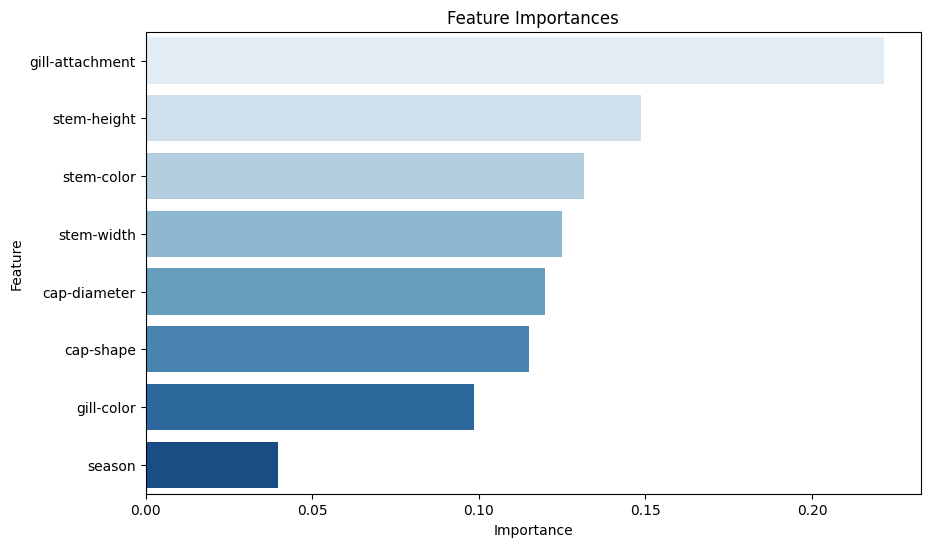

In [14]:
best_model = random_search_rf.best_estimator_

# Extract the classifier from the pipeline
classifier = best_model.named_steps['classifier']

# Extract feature importances from the best model
importances = classifier.feature_importances_

# Create a DataFrame to store feature importances along with their names
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the DataFrame by importance values
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='Blues')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


## Final Evaluation on the Test Set

After hyperparameter tuning and selecting the best model, the model was evaluated on the test set to assess its performance.

### Best Parameters:
The hyperparameters that yielded the highest performance during the randomized search were as follows:
- Number of Estimators: 300
- Minimum Samples Split: 5
- Minimum Samples Leaf: 1
- Maximum Depth: 15
- Bootstrap: True

### Classification Report:
The classification report provides a detailed overview of the model's performance across different metrics such as precision, recall, and F1-score for each class in the test set. 

- **Precision**: Precision measures the proportion of true positive predictions among all positive predictions. For both classes (0 and 1), the precision scores are exceptionally high, indicating that the model has a low false positive rate.
- **Recall**: Recall(sensitivity) measures the proportion of TPs that were correctly identified by the model. Similarly, the recall scores for both classes are high, suggesting that the model effectively captures most of the positive instances.
- **F1-score**: The F1-score provides a balance between the two previous metrics. In this case, the F1-scores are close to 1 for both classes, indicating a strong balance between precision and recall.
- **Support**: Support refers to the number of actual occurrences of each class in the test set.

### Confusion Matrix:
The confusion matrix visually represents the model's performance by comparing the actual and predicted classes. In this case, the confusion matrix highlights the high number of TPs and TNs, with minimal occurrences of FPs and FNs.

### ROC Curve:
The Receiver Operating Characteristic curve illustrates the trade-off between the sensitivity and the specificity across different threshold values. The area under the ROC curve (ROC AUC) serves as a summary metric for the model's discriminative ability. In this case, the ROC curve exhibits excellent performance, and the high ROC AUC value further confirms the model's strong predictive capability.

Based on the evaluation results, it can be said that the model performs very well on the test set, demonstrating high accuracy in classifying the target variable.

Best Parameters for Random Forest Classifier: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 15, 'classifier__bootstrap': True}
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4783
           1       0.99      0.99      0.99      5964

    accuracy                           0.99     10747
   macro avg       0.99      0.99      0.99     10747
weighted avg       0.99      0.99      0.99     10747



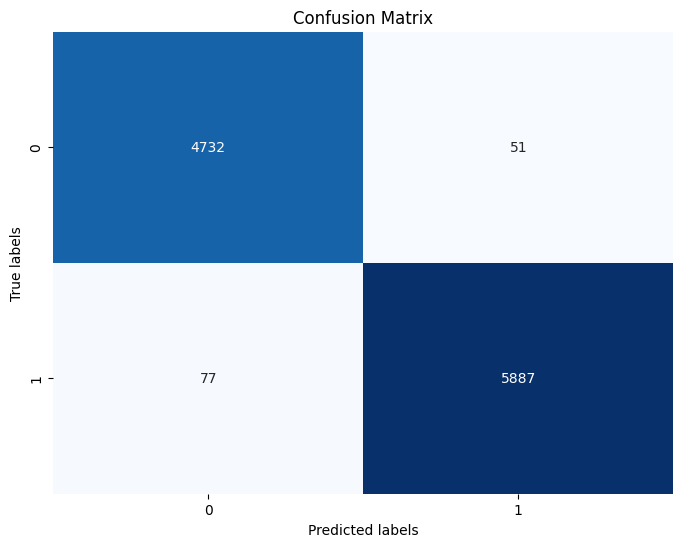

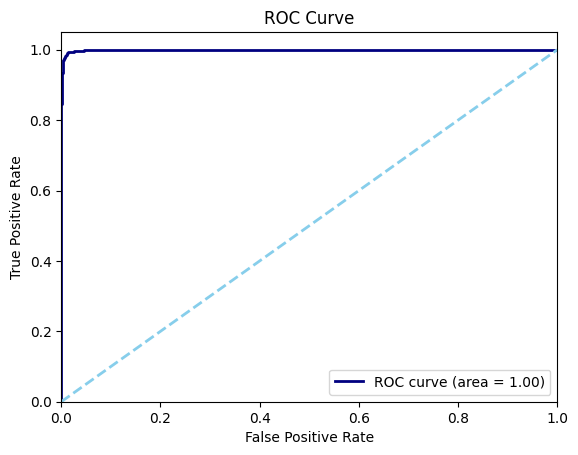

In [15]:
best_params = random_search_rf.best_params_
print(f"Best Parameters for Random Forest Classifier:", best_params)
# Evaluate on test set
y_pred = best_model.predict(X_test)
print("Classification report:")
print(classification_report(y_test, y_pred))

# Calculate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Plot the ROC curve
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='navy', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='skyblue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()